#Introduction

In this notebook, we will train a model to classify whether an image has cracks using the pretrained model resnet18. The model will be trained on a set of images with cracks (positive images) and images without cracks (negative images). Applying the method of transfer learning, we will only train the output layer without retraining the parameters of resnet18.

#Import Necessary Libraries

In [1]:
#Import libraries
import torchvision.models as models
from torchvision import transforms
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt

#Some Setup

In [2]:
#Set torch manual seed
torch.manual_seed(1729)

In [3]:
#Use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

#Download and Set Up the Data

In [4]:
#Download and unzip positive images
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip
!unzip -q Positive_tensors.zip

--2024-08-03 08:48:01--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2598656062 (2.4G) [application/zip]
Saving to: ‘Positive_tensors.zip’

Positive_tensors.zi 100%[===================>]   2.42G  11.9MB/s    in 4m 15s  

2024-08-03 08:52:17 (9.71 MB/s) - ‘Positive_tensors.zip’ saved [2598656062/2598656062]



In [5]:
#Download and unzip negative images
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
!unzip -q Negative_tensors.zip

--2024-08-03 08:54:40--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2111408108 (2.0G) [application/zip]
Saving to: ‘Negative_tensors.zip’

Negative_tensors.zi 100%[===================>]   1.97G  24.5MB/s    in 81s     

2024-08-03 08:56:01 (25.0 MB/s) - ‘Negative_tensors.zip’ saved [2111408108/2111408108]



In [6]:
#Create dataset class
class Dataset(Dataset):

    #Constructor
    def __init__(self, transform=None, train=True):
        directory = os.getcwd()
        positive = 'Positive_tensors'
        negative = 'Negative_tensors'
        positive_file_path = os.path.join(directory, positive)
        negative_file_path = os.path.join(directory, negative)
        positive_files = [os.path.join(positive_file_path, file) for file in os.listdir(positive_file_path) if file.endswith('.pt')]
        negative_files = [os.path.join(negative_file_path, file) for file in os.listdir(negative_file_path) if file.endswith('.pt')]
        number_of_samples = len(positive_files)+len(negative_files)
        #The list of all files
        self.all_files = [None]*number_of_samples
        self.all_files[::2] = positive_files
        self.all_files[1::2] = negative_files
        #The transform on images
        self.transform = transform
        #The tensor of labels
        self.Y = torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2] = 1
        self.Y[1::2] = 0
        #Split train and validation data
        if train:
            self.all_files = self.all_files[0:30000]
            self.Y = self.Y[0:30000]
            self.len = len(self.all_files)
        else:
            self.all_files = self.all_files[30000:]
            self.Y = self.Y[30000:]
            self.len = len(self.all_files)

    #Get the length
    def __len__(self):
        return self.len

    #Getter
    def __getitem__(self, idx):
        image = torch.load(self.all_files[idx])
        y = self.Y[idx]
        if self.transform:
            image = self.transform(image)
        return image, y

In [7]:
#Define train dataset
train_dataset = Dataset(train=True)

#Define validation dataset
validation_dataset = Dataset(train=False)

#Define the Model to be Trained

In [8]:
#Load the pretrained model resnet18
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 84.5MB/s]


In [9]:
#Set the parameters of the pretrained model to be untrainable
for param in model.parameters():
    param.requires_grad = False

In [10]:
#Reset the output layer to predict only 2 classes
input_feature = model.fc.in_features
model.fc = nn.Linear(input_feature, 2)

In [11]:
#See the structure of the model
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#Train the Model

In [12]:
#Criterion
criterion = nn.CrossEntropyLoss()

#Dataloader objects
train_loader = DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=100)

#Optimizer
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad], lr=0.001)

In [13]:
#Train with 5 epochs
n_epochs = 5
#Save training loss as a list
loss_list = []
#Save validation accuracy as a list
accuracy_list = []

for epoch in range(n_epochs):

    #Train and keep track of loss for each epoch
    Loss = 0
    for x, y in train_loader:
        model.train()
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        z = model(x)
        loss = criterion(z, y)
        loss.backward()
        optimizer.step()
        Loss += loss.cpu().item()
    loss_list.append(Loss)

    #Test and keep track of accuracy for each epoch
    correct=0
    for x_test, y_test in validation_loader:
        model.eval()
        x_test, y_test = x_test.to(device), y_test.to(device)
        z = model(x_test)
        _, yhat = torch.max(z.data, 1)
        correct += (yhat == y_test).sum().item()
    accuracy = correct/len(validation_dataset)
    accuracy_list.append(accuracy)

#The Model's Performance

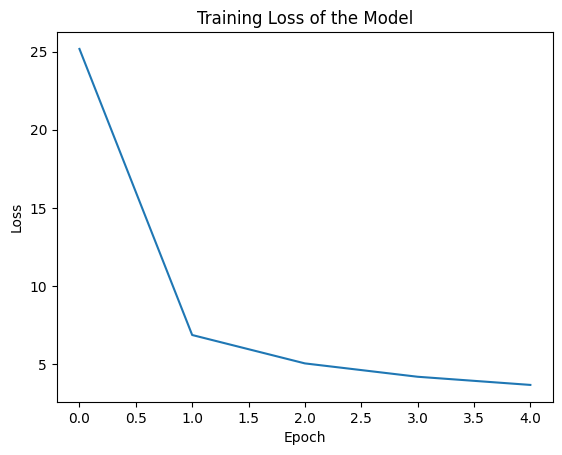

In [14]:
#Plot training loss
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss of the Model')
plt.show()

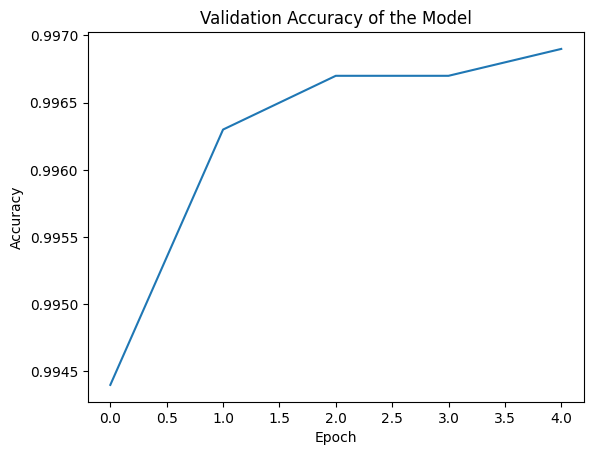

In [15]:
#Plot validation accuracy
plt.plot(accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy of the Model')
plt.show()

In [16]:
#Print 5 examples of misclassified images
count = 0
for i, (x, y) in enumerate(validation_dataset):
    if count == 5:
        break
    x, y = x.to(device), y.to(device)
    z = model(x.reshape(-1, 3, 224, 224))
    _, yhat = torch.max(z, 1)
    if yhat != y:
        print("Sample", i, "Predicted value:", yhat[0].item(), "Actual value:", y.item())
        count += 1

Sample 34 Predicted value: 0 Actual value: 1
Sample 75 Predicted value: 1 Actual value: 0
Sample 214 Predicted value: 0 Actual value: 1
Sample 1501 Predicted value: 1 Actual value: 0
Sample 2356 Predicted value: 0 Actual value: 1
